# 4x2 Beam with multiple particle sets, rolling load, PR #27

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np

particles = []

for i in range(4):  # for each of the 4 elements along the x-axis
    for j in range(2):  # for each of the 2 elements along the y-axis
        for x in [0.125, 0.375, 0.625, 0.875]:
            for y in [0.125, 0.375, 0.625, 0.875]:
                particles.append([[i + x, j + y]])

print(particles)

orig = np.array([
    [[0.125, 0.125]], [[0.125, 0.375]], [[0.125, 0.625]], [[0.125, 0.875]],
    [[0.375, 0.125]], [[0.375, 0.375]], [[0.375, 0.625]], [[0.375, 0.875]],
    [[0.625, 0.125]], [[0.625, 0.375]], [[0.625, 0.625]], [[0.625, 0.875]],
    [[0.875, 0.125]], [[0.875, 0.375]], [[0.875, 0.625]], [[0.875, 0.875]],

    [[0.125, 1.125]], [[0.125, 1.375]], [[0.125, 1.625]], [[0.125, 1.875]],
    [[0.375, 1.125]], [[0.375, 1.375]], [[0.375, 1.625]], [[0.375, 1.875]],
    [[0.625, 1.125]], [[0.625, 1.375]], [[0.625, 1.625]], [[0.625, 1.875]],
    [[0.875, 1.125]], [[0.875, 1.375]], [[0.875, 1.625]], [[0.875, 1.875]],

    [[1.125, 0.125]], [[1.125, 0.375]], [[1.125, 0.625]], [[1.125, 0.875]],
    [[1.375, 0.125]], [[1.375, 0.375]], [[1.375, 0.625]], [[1.375, 0.875]],
    [[1.625, 0.125]], [[1.625, 0.375]], [[1.625, 0.625]], [[1.625, 0.875]],
    [[1.875, 0.125]], [[1.875, 0.375]], [[1.875, 0.625]], [[1.875, 0.875]],

    [[1.125, 1.125]], [[1.125, 1.375]], [[1.125, 1.625]], [[1.125, 1.875]],
    [[1.375, 1.125]], [[1.375, 1.375]], [[1.375, 1.625]], [[1.375, 1.875]],
    [[1.625, 1.125]], [[1.625, 1.375]], [[1.625, 1.625]], [[1.625, 1.875]],
    [[1.875, 1.125]], [[1.875, 1.375]], [[1.875, 1.625]], [[1.875, 1.875]],

    [[2.125, 0.125]], [[2.125, 0.375]], [[2.125, 0.625]], [[2.125, 0.875]],
    [[2.375, 0.125]], [[2.375, 0.375]], [[2.375, 0.625]], [[2.375, 0.875]],
    [[2.625, 0.125]], [[2.625, 0.375]], [[2.625, 0.625]], [[2.625, 0.875]],
    [[2.875, 0.125]], [[2.875, 0.375]], [[2.875, 0.625]], [[2.875, 0.875]],

    [[2.125, 1.125]], [[2.125, 1.375]], [[2.125, 1.625]], [[2.125, 1.875]],
    [[2.375, 1.125]], [[2.375, 1.375]], [[2.375, 1.625]], [[2.375, 1.875]],
    [[2.625, 1.125]], [[2.625, 1.375]], [[2.625, 1.625]], [[2.625, 1.875]],
    [[2.875, 1.125]], [[2.875, 1.375]], [[2.875, 1.625]], [[2.875, 1.875]],

    [[3.125, 0.125]], [[3.125, 0.375]], [[3.125, 0.625]], [[3.125, 0.875]],
    [[3.375, 0.125]], [[3.375, 0.375]], [[3.375, 0.625]], [[3.375, 0.875]],
    [[3.625, 0.125]], [[3.625, 0.375]], [[3.625, 0.625]], [[3.625, 0.875]],
    [[3.875, 0.125]], [[3.875, 0.375]], [[3.875, 0.625]], [[3.875, 0.875]],

    [[3.125, 1.125]], [[3.125, 1.375]], [[3.125, 1.625]], [[3.125, 1.875]],
    [[3.375, 1.125]], [[3.375, 1.375]], [[3.375, 1.625]], [[3.375, 1.875]],
    [[3.625, 1.125]], [[3.625, 1.375]], [[3.625, 1.625]], [[3.625, 1.875]],
    [[3.875, 1.125]], [[3.875, 1.375]], [[3.875, 1.625]], [[3.875, 1.875]]
]

)

nodes = np.array([[0,0], [1,0], [2,0], [3,0], [4,0], [0,1], [1,1], [2,1], [3,1], [4,1], [0,2], [1,2], [2,2], [3,2], [4,2]])


[[[0.125, 0.125]], [[0.125, 0.375]], [[0.125, 0.625]], [[0.125, 0.875]], [[0.375, 0.125]], [[0.375, 0.375]], [[0.375, 0.625]], [[0.375, 0.875]], [[0.625, 0.125]], [[0.625, 0.375]], [[0.625, 0.625]], [[0.625, 0.875]], [[0.875, 0.125]], [[0.875, 0.375]], [[0.875, 0.625]], [[0.875, 0.875]], [[0.125, 1.125]], [[0.125, 1.375]], [[0.125, 1.625]], [[0.125, 1.875]], [[0.375, 1.125]], [[0.375, 1.375]], [[0.375, 1.625]], [[0.375, 1.875]], [[0.625, 1.125]], [[0.625, 1.375]], [[0.625, 1.625]], [[0.625, 1.875]], [[0.875, 1.125]], [[0.875, 1.375]], [[0.875, 1.625]], [[0.875, 1.875]], [[1.125, 0.125]], [[1.125, 0.375]], [[1.125, 0.625]], [[1.125, 0.875]], [[1.375, 0.125]], [[1.375, 0.375]], [[1.375, 0.625]], [[1.375, 0.875]], [[1.625, 0.125]], [[1.625, 0.375]], [[1.625, 0.625]], [[1.625, 0.875]], [[1.875, 0.125]], [[1.875, 0.375]], [[1.875, 0.625]], [[1.875, 0.875]], [[1.125, 1.125]], [[1.125, 1.375]], [[1.125, 1.625]], [[1.125, 1.875]], [[1.375, 1.125]], [[1.375, 1.375]], [[1.375, 1.625]], [[1.375, 

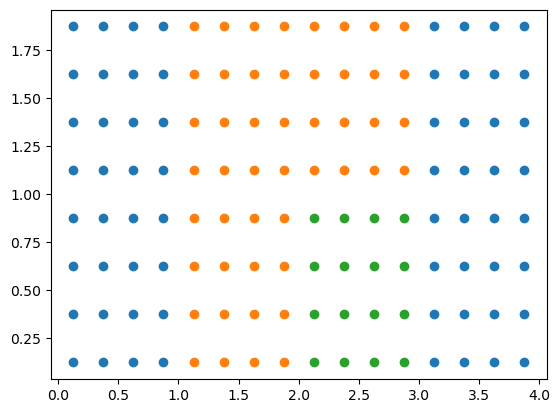

In [90]:
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt
with open("particles.json", "r") as f:
    ploc = jnp.asarray(json.load(f))

p1 = jnp.concatenate((ploc[:16], ploc[48:80], ploc[-16:]))
p2 = jnp.concatenate((ploc[16:32], ploc[80:112]))
p3 = ploc[32:48]

plt.scatter(p1[:,0,0], p1[:,0,1])
plt.scatter(p2[:,0,0], p2[:,0,1])
plt.scatter(p3[:,0,0], p3[:,0,1])
plt.show()

In [15]:
from typing import NamedTuple
from functools import partial
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax
from tqdm import tqdm

from diffmpm.constraint import Constraint
from diffmpm.element import Quad4N, Quad4NState
from diffmpm.explicit import ExplicitSolver
from diffmpm.forces import NodalForce
from diffmpm.functions import Unit
from diffmpm.io import Config
from diffmpm.materials import init_simple, init_linear_elastic
from diffmpm.particle import _ParticlesState, init_particle_state

jax.config.update("jax_platform_name", "gpu")

config = Config("./../../benchmarks/2d/uniaxial_stress/mpm-uniaxial-stress.toml")
# config = Config("./benchmarks/2d/uniaxial_particle_traction/mpm-particle-traction.toml")
# config = Config("./benchmarks/2d/uniaxial_nodal_forces/mpm-nodal-forces.toml")
# config = Config("./benchmarks/2d/hydrostatic_column/mpm.toml")
# parsed_config = config.parse()
# cnf = [NodalForce(node_ids=jnp.array([0, 1]), function=Unit(-1), dir=1, force=1.5)]
# material = NamedTuple("Simple", density=1, E=1, state_vars={})
# ploc = jnp.array([[0.5, 0.5], [0.5, 0.5]]).reshape(2, 1, 2)
# pmat = material(density=1.0, E=1.0, state_vars={})
# pmat = init_simple({"density": 1, "E": 100, "id": 1})
# peids = jnp.array([1])
# particles = [init_particle_state(ploc, pmat, peids)]

# cls = Quad4N(total_elements=1)
# elements = cls.init_state(
#     (1, 1),
#     1,
#     (1, 1),
#     [(jnp.array([0]), Constraint(0, 2))],
#     concentrated_nodal_forces=cnf,
# )

solver = ExplicitSolver(
    el_type=config.parsed_config["elementor"],
    tol=1e-12,
    scheme=config.parsed_config["meta"]["scheme"],
    dt=config.parsed_config["meta"]["dt"],
    velocity_update=config.parsed_config["meta"]["velocity_update"],
    sim_steps=config.parsed_config["meta"]["nsteps"],
    out_steps=config.parsed_config["output"]["step_frequency"],
    out_dir=config.parsed_config["output"]["format"],
    gravity=config.parsed_config["external_loading"]["gravity"],
)

init_vals = solver.init_state(
    {
        "elements": config.parsed_config["elements"],
        "particles": config.parsed_config["particles"],
        "particle_surface_traction": config.parsed_config["particle_surface_traction"],
    }
)

jit_updated = init_vals
jitted_update = jax.jit(solver.update)
for step in tqdm(range(20)):
    jit_updated = jitted_update(jit_updated, step + 1)

true_vel = jit_updated.particles[0].stress


# def compute_loss(params, *, solver, target_vel, config):
#     material = init_linear_elastic(
#         {
#             "youngs_modulus": params["ym"],
#             "density": 1,
#             "poisson_ratio": 0,
#             "id": -1,
#         }
#     )
#     particles_ = [
#         init_particle_state(
#             config.parsed_config["particles"][0].loc,
#             material,
#             config.parsed_config["particles"][0].element_ids,
#             init_vel=jnp.asarray([1.0, 0.0]),
#         )
#     ]
#     init_vals = solver.init_state(
#         {
#             "elements": config.parsed_config["elements"],
#             "particles": particles_,
#             "particle_surface_traction": config.parsed_config[
#                 "particle_surface_traction"
#             ],
#         }
#     )
#     result = init_vals
#     for step in tqdm(range(20), leave=False):
#         result = jitted_update(result, step + 1)
#     vel = result.particles[0].stress
#     loss = jnp.linalg.norm(vel - target_vel)
#     return loss


# def optax_adam(params, niter, mpm, target_vel, config):
#     # Initialize parameters of the model + optimizer.
#     start_learning_rate = 4
#     optimizer = optax.adam(start_learning_rate)
#     opt_state = optimizer.init(params)

#     param_list = {"ym": [], "pr": []}
#     loss_list = []
#     # A simple update loop.
#     t = tqdm(range(niter), desc=f"E: {params}")
#     partial_f = partial(compute_loss, solver=mpm, target_vel=target_vel, config=config)
#     for _ in t:
#         lo, grads = jax.value_and_grad(partial_f, argnums=0)(params)
#         updates, opt_state = optimizer.update(grads, opt_state)
#         params = optax.apply_updates(params, updates)
#         t.set_description(f"YM: {params['ym']:.2f}")
#         param_list["ym"].append(params["ym"])
#         # param_list["pr"].append(params["pr"])
#         loss_list.append(lo)
#     return param_list, loss_list


# # params = {"pr": 0.4}
# params = {"ym": 1101.0}
# # material = init_simple({"E": params, "density": 1, "id": -1})
# material = init_linear_elastic(
#     {
#         "youngs_modulus": params["ym"],
#         "density": 1,
#         "poisson_ratio": 0,
#         "id": -1,
#     }
# )
# particles = [
#     init_particle_state(
#         config.parsed_config["particles"][0].loc,
#         material,
#         config.parsed_config["particles"][0].element_ids,
#     )
# ]

# init_vals = solver.init_state(
#     {
#         "elements": config.parsed_config["elements"],
#         "particles": particles,
#         "particle_surface_traction": config.parsed_config["particle_surface_traction"],
#     }
# )
# param_list, loss_list = optax_adam(
#     params, 200, solver, true_vel, config
# )  # ADAM optimizer

# fig, ax = plt.subplots(1, 2, figsize=(16, 6))
# ax[0].plot(param_list["ym"], "ko", markersize=2, label="Youngs Modulus")
# ax[0].grid()
# ax[0].legend()
# ax[1].plot(loss_list, "ko", markersize=2, label="Loss")
# ax[1].grid()
# ax[1].legend()
# plt.show()

100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


In [5]:
jax.clear_caches()

In [4]:
from typing import NamedTuple
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import jax
from jax import jit
import jax.numpy as jnp
import optax
from tqdm import tqdm
from IPython.display import HTML, display

from diffmpm.constraint import Constraint
from diffmpm.element import Quad4N, Quad4NState
from diffmpm.explicit import ExplicitSolver
from diffmpm.forces import NodalForce
from diffmpm.functions import Unit, Linear
from diffmpm.io import Config
from diffmpm.materials import init_simple, init_linear_elastic
from diffmpm.particle import _ParticlesState, init_particle_state

@jit
def rolling_gaussian_generator(velocity, frequency, node_x_locs, N=5):
    time_to_center = node_x_locs / velocity

    fc = frequency
    t_width = N / fc  # half-width of time range

    t = jnp.linspace(-t_width, t_width, 2 * 100, endpoint=False)
    i, q, e = gausspulse(t, fc=fc)

    t_pad = jnp.array([-t_width - 1e-16, t_width + 1e-16])
    e_pad = jnp.array([0, 0])

    t = jnp.concatenate([t_pad[:1], t, t_pad[1:]])
    e = jnp.concatenate([e_pad[:1], e, e_pad[1:]])

    xvalues = t + time_to_center[:, jnp.newaxis]
    fxvalues = e
    return xvalues, fxvalues

@jit
def gausspulse(t, fc=1000, bw=0.5, bwr=-6):
    """
    Return a Gaussian modulated sinusoid:

        ``exp(-a t^2) exp(1j*2*pi*fc*t).``

    Parameters
    ----------
    t : ndarray
        Input array.
    fc : float, optional
        Center frequency (e.g. Hz).  Default is 1000.
    bw : float, optional
        Fractional bandwidth in frequency domain of pulse (e.g. Hz).
        Default is 0.5.
    bwr : float, optional
        Reference level at which fractional bandwidth is calculated (dB).
        Default is -6.

    Returns
    -------
    yI : ndarray
        Real part of signal.
    yQ : ndarray
        Imaginary part of signal.
    yenv : ndarray
        Envelope of signal.
    """

    # Convert t to a jnp array if it's not already
    t = jnp.asarray(t)

    # exp(-a t^2) <->  sqrt(pi/a) exp(-pi^2/a * f^2)  = g(f)
    ref = jnp.power(10.0, bwr / 20.0)
    
    # pi^2/a * fc^2 * bw^2 /4=-log(ref)
    a = -(jnp.pi * fc * bw) ** 2 / (4.0 * jnp.log(ref))

    yenv = jnp.exp(-a * t * t)
    yI = yenv * jnp.cos(2 * jnp.pi * fc * t)
    yQ = yenv * jnp.sin(2 * jnp.pi * fc * t)

    return yI, yQ, yenv

jax.config.update("jax_platform_name", "gpu")

config = Config("./2d-beam.toml")

solver = ExplicitSolver(
    el_type=config.parsed_config["elementor"],
    tol=1e-12,
    scheme=config.parsed_config["meta"]["scheme"],
    dt=config.parsed_config["meta"]["dt"],
    velocity_update=config.parsed_config["meta"]["velocity_update"],
    sim_steps=config.parsed_config["meta"]["nsteps"],
    out_steps=config.parsed_config["output"]["step_frequency"],
    out_dir=config.parsed_config["output"]["format"],
    gravity=config.parsed_config["external_loading"]["gravity"],
)
constraints = [
    (jnp.array([0,4,10,14]), Constraint(0, 0.0)), 
    (jnp.array([0,4,10,14]), Constraint(1, 0.0))
    ]
# external forces
velocity = 4
frequency = 5
node_x_locs = jnp.arange(5)
xvalues, fxvalues = rolling_gaussian_generator(velocity, frequency, node_x_locs)

cnfs = []
true_f = -50
for i in range(5):
    fn = Linear(i, xvalues[i, :], fxvalues)
    cnfs.append(NodalForce(node_ids=[10 + i], function=fn, dir=1, force=true_f))
elementor = Quad4N(total_elements=8)
elements = elementor.init_state(
    [4,2],
    8,
    [1,1],
    constraints,
    concentrated_nodal_forces=cnfs,
)
init_vals = solver.init_state(
    {
        "elements": elements,
        "particles": config.parsed_config["particles"],
        "particle_surface_traction": [],
    }
)

jit_updated = init_vals
jitted_update = jit(solver.update)
result_locs = []
for step in tqdm(range(20)):
    jit_updated = jitted_update(jit_updated, step + 1)
    result_locs.append(jit_updated.particles[0].loc)

result_locs = jnp.array(result_locs).squeeze(axis=2)
true_vel = jit_updated.particles[0].stress

fig, ax = plt.subplots()

artists = []
for i in range(20):
    container = ax.scatter(result_locs[i,:,0], result_locs[i,:,1], label='deformed', color='b')
    artists.append([container])


ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
display(HTML(ani.to_jshtml()))

  0%|          | 0/20 [00:00<?, ?it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import jax
from jax import grad, jit, value_and_grad
from tqdm import tqdm
import json
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
from IPython.display import display


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from diffmpm.constraint import Constraint
from diffmpm.element import Quad4N, Quad4NState
from diffmpm.explicit import ExplicitSolver
from diffmpm.forces import NodalForce
from diffmpm.functions import Unit, Linear
from diffmpm.io import Config
from diffmpm.materials import init_simple, init_linear_elastic
from diffmpm.particle import _ParticlesState, init_particle_state

jax.clear_caches()
jax.config.update("jax_platform_name", "cpu")
@jit
def rolling_gaussian_generator(velocity, frequency, node_x_locs, N=5):
    time_to_center = node_x_locs / velocity

    fc = frequency
    t_width = N / fc  # half-width of time range

    t = jnp.linspace(-t_width, t_width, 2 * 100, endpoint=False)
    i, q, e = gausspulse(t, fc=fc)

    t_pad = jnp.array([-t_width - 1e-16, t_width + 1e-16])
    e_pad = jnp.array([0, 0])

    t = jnp.concatenate([t_pad[:1], t, t_pad[1:]])
    e = jnp.concatenate([e_pad[:1], e, e_pad[1:]])

    xvalues = t + time_to_center[:, jnp.newaxis]
    fxvalues = e
    return xvalues, fxvalues

@jit
def gausspulse(t, fc=1000, bw=0.5, bwr=-6):
    """
    Return a Gaussian modulated sinusoid:

        ``exp(-a t^2) exp(1j*2*pi*fc*t).``

    Parameters
    ----------
    t : ndarray
        Input array.
    fc : float, optional
        Center frequency (e.g. Hz).  Default is 1000.
    bw : float, optional
        Fractional bandwidth in frequency domain of pulse (e.g. Hz).
        Default is 0.5.
    bwr : float, optional
        Reference level at which fractional bandwidth is calculated (dB).
        Default is -6.

    Returns
    -------
    yI : ndarray
        Real part of signal.
    yQ : ndarray
        Imaginary part of signal.
    yenv : ndarray
        Envelope of signal.
    """

    # Convert t to a jnp array if it's not already
    t = jnp.asarray(t)

    # exp(-a t^2) <->  sqrt(pi/a) exp(-pi^2/a * f^2)  = g(f)
    ref = jnp.power(10.0, bwr / 20.0)
    
    # pi^2/a * fc^2 * bw^2 /4=-log(ref)
    a = -(jnp.pi * fc * bw) ** 2 / (4.0 * jnp.log(ref))

    yenv = jnp.exp(-a * t * t)
    yI = yenv * jnp.cos(2 * jnp.pi * fc * t)
    yQ = yenv * jnp.sin(2 * jnp.pi * fc * t)

    return yI, yQ, yenv

# material
E_true = [1000, 1000, 1000]
materials = [init_linear_elastic({"youngs_modulus": E_true[i], "poisson_ratio" : 0, "density": 1, "id" : i}) for i in range(len(E_true))]

# particles
with open("particles.json", "r") as f:
    ploc = jnp.asarray(json.load(f))

particles = []
particles.append(init_particle_state(ploc, materials[0], jnp.zeros(ploc.shape[0], dtype=jnp.int32)))

# external forces
velocity = 4
frequency = 5
node_x_locs = jnp.arange(5)
xvalues, fxvalues = rolling_gaussian_generator(velocity, frequency, node_x_locs)

cnfs = []
true_f = -50
for i in range(5):
    fn = Linear(i, xvalues[i, :], fxvalues)
    cnfs.append(NodalForce(node_ids=[10 + i], function=fn, dir=1, force=true_f))
pst = []

# element
elementor = Quad4N(total_elements=8)
constraints = [
    (jnp.array([0,4,10,14]), Constraint(0, 0.0)), 
    (jnp.array([0,4,10,14]), Constraint(1, 0.0))
    ]
elements = elementor.init_state([4,2], 8, [1,1], constraints, concentrated_nodal_forces=cnfs)


solver = ExplicitSolver(
    el_type=elementor,
    tol=1e-12,
    scheme='usf',
    dt=0.01,
    velocity_update=False,
    sim_steps=100,
    out_steps=1,
    out_dir='./results/',
    gravity=0,
)

init_vals = solver.init_state(
    {
        "elements" : elements,
        "particles" : particles,
        "particle_surface_traction" : pst,
    }
)



do_jit = True
if do_jit:
    jitted_update = jax.jit(solver.update)
    t_steps = 100
else:
    jitted_update = solver.update
    t_steps = 100


jit_updated = init_vals
result_locs = []
for step in tqdm(range(t_steps)):
    jit_updated = jitted_update(jit_updated, step + 1)
    result_locs.append(jit_updated.particles[0].loc)

result_locs = jnp.array(result_locs).squeeze(axis=2)
true_vel = jit_updated.particles[0].stress

fig, ax = plt.subplots()

artists = []
for i in range(t_steps):
    container = ax.scatter(result_locs[i,:,0], result_locs[i,:,1], label='deformed', color='b')
    artists.append([container])


ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)



display(HTML(ani.to_jshtml()))

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [4]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import jax
from jax import grad, jit, value_and_grad
from tqdm import tqdm
import json
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
from IPython.display import display


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from diffmpm.constraint import Constraint
from diffmpm.element import Quad4N, Quad4NState
from diffmpm.explicit import ExplicitSolver
from diffmpm.forces import NodalForce
from diffmpm.functions import Unit, Linear
from diffmpm.io import Config
from diffmpm.materials import init_simple, init_linear_elastic
from diffmpm.particle import _ParticlesState, init_particle_state

jax.config.update("jax_platform_name", "gpu")
@jit
def rolling_gaussian_generator(velocity, frequency, node_x_locs, N=5):
    time_to_center = node_x_locs / velocity

    fc = frequency
    t_width = N / fc  # half-width of time range

    t = jnp.linspace(-t_width, t_width, 2 * 100, endpoint=False)
    i, q, e = gausspulse(t, fc=fc)

    t_pad = jnp.array([-t_width - 1e-16, t_width + 1e-16])
    e_pad = jnp.array([0, 0])

    t = jnp.concatenate([t_pad[:1], t, t_pad[1:]])
    e = jnp.concatenate([e_pad[:1], e, e_pad[1:]])

    xvalues = t + time_to_center[:, jnp.newaxis]
    fxvalues = e
    return xvalues, fxvalues

@jit
def gausspulse(t, fc=1000, bw=0.5, bwr=-6):
    """
    Return a Gaussian modulated sinusoid:

        ``exp(-a t^2) exp(1j*2*pi*fc*t).``

    Parameters
    ----------
    t : ndarray
        Input array.
    fc : float, optional
        Center frequency (e.g. Hz).  Default is 1000.
    bw : float, optional
        Fractional bandwidth in frequency domain of pulse (e.g. Hz).
        Default is 0.5.
    bwr : float, optional
        Reference level at which fractional bandwidth is calculated (dB).
        Default is -6.

    Returns
    -------
    yI : ndarray
        Real part of signal.
    yQ : ndarray
        Imaginary part of signal.
    yenv : ndarray
        Envelope of signal.
    """

    # Convert t to a jnp array if it's not already
    t = jnp.asarray(t)

    # exp(-a t^2) <->  sqrt(pi/a) exp(-pi^2/a * f^2)  = g(f)
    ref = jnp.power(10.0, bwr / 20.0)
    
    # pi^2/a * fc^2 * bw^2 /4=-log(ref)
    a = -(jnp.pi * fc * bw) ** 2 / (4.0 * jnp.log(ref))

    yenv = jnp.exp(-a * t * t)
    yI = yenv * jnp.cos(2 * jnp.pi * fc * t)
    yQ = yenv * jnp.sin(2 * jnp.pi * fc * t)

    return yI, yQ, yenv


# material
E_true = [1100, 900, 500]
materials = [
    init_linear_elastic(
        {
            "youngs_modulus": E_true[i], 
            "poisson_ratio" : 0, 
            "density": 1, 
            "id" : i
        }
    ) for i in range(len(E_true))
]

# particles
with open("particles.json", "r") as f:
    ploc = jnp.asarray(json.load(f))

particles = []
for i in range(8):
    if i == 2:
        material = materials[2]
    elif i in [1, 5, 6]:
        material = materials[1]
    else:
        material = materials[0]
    particles.append(
        init_particle_state(
            ploc[16*i:16*(i+1)], 
            material, 
            jnp.zeros(ploc[16*i:16*(i+1)].shape[0], dtype=jnp.int32)
        )
    )
# external forces
velocity = 4
frequency = 5
node_x_locs = jnp.arange(5)
xvalues, fxvalues = rolling_gaussian_generator(velocity, frequency, node_x_locs)

cnfs = []
true_f = -50
for i in range(5):
    fn = Linear(i, xvalues[i, :], fxvalues)
    cnfs.append(NodalForce(node_ids=[10 + i], function=fn, dir=1, force=true_f))
pst = []

# element
elementor = Quad4N(total_elements=8)
constraints = [
    (jnp.array([0,4,10,14]), Constraint(0, 0.0)), 
    (jnp.array([0,4,10,14]), Constraint(1, 0.0))
    ]
elements = elementor.init_state([4,2], 8, [1,1], constraints, concentrated_nodal_forces=cnfs)


solver = ExplicitSolver(
    el_type=elementor,
    tol=1e-12,
    scheme='usf',
    dt=0.01,
    velocity_update=False,
    sim_steps=1000,
    out_steps=1,
    out_dir='./results/',
    gravity=0,
)

init_vals = solver.init_state(
    {
        "elements" : elements,
        "particles" : particles,
        "particle_surface_traction" : pst,
    }
)



do_jit = True
if do_jit:
    jitted_update = jax.jit(solver.update)
    t_steps = 100
else:
    jitted_update = solver.update
    t_steps = 2


jit_updated = init_vals
result_locs = []
result_strain = []

import traceback
try:
    for step in tqdm(range(t_steps)):
        jit_updated = jitted_update(jit_updated, step + 1)
        result_locs.append(jnp.vstack([particle.loc for particle in jit_updated.particles]))
        result_strain.append(jnp.vstack([particle.strain for particle in jit_updated.particles]))
except Exception as e:
    print("Exception encountered:", e)
    print(traceback.format_exc())
    with open("error_log.txt", "w") as f:
        traceback.print_exc(file=f)


result_locs = jnp.array(result_locs).squeeze()
result_strain = jnp.array(result_strain).squeeze()
indices = jnp.concatenate([jnp.arange(0, 4) + i for i in range(0, 32, 8)])
target_rel_strain = jnp.diff(result_strain[:, indices][:, 4:-4, 0], axis=1)

fig, ax = plt.subplots()

artists = []
for i in range(t_steps):
    container = ax.scatter(result_locs[i,:,0], result_locs[i,:,1], label='deformed', color='b')
    artists.append([container])


ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)



display(HTML(ani.to_jshtml()))

ImportError: cannot import name 'api' from 'jax' (/home/username/miniconda3/envs/env_surrogate3/lib/python3.11/site-packages/jax/__init__.py)

In [11]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import jax
from jax import grad, jit, value_and_grad
from tqdm import tqdm
import json
from scipy import signal
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
from IPython.display import display


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from diffmpm.constraint import Constraint
from diffmpm.element import Quad4N, Quad4NState
from diffmpm.explicit import ExplicitSolver
from diffmpm.forces import NodalForce
from diffmpm.functions import Unit, Linear
from diffmpm.io import Config
from diffmpm.materials import init_simple, init_linear_elastic
from diffmpm.particle import _ParticlesState, init_particle_state
@jit
def rolling_gaussian_generator(velocity, frequency, node_x_locs, N=5):
    time_to_center = node_x_locs / velocity

    fc = frequency
    t_width = N / fc  # half-width of time range

    t = jnp.linspace(-t_width, t_width, 2 * 100, endpoint=False)
    i, q, e = gausspulse(t, fc=fc)

    t_pad = jnp.array([-t_width - 1e-16, t_width + 1e-16])
    e_pad = jnp.array([0, 0])

    t = jnp.concatenate([t_pad[:1], t, t_pad[1:]])
    e = jnp.concatenate([e_pad[:1], e, e_pad[1:]])

    xvalues = t + time_to_center[:, jnp.newaxis]
    fxvalues = e
    return xvalues, fxvalues

@jit
def gausspulse(t, fc=1000, bw=0.5, bwr=-6):
    """
    Return a Gaussian modulated sinusoid:

        ``exp(-a t^2) exp(1j*2*pi*fc*t).``

    Parameters
    ----------
    t : ndarray
        Input array.
    fc : float, optional
        Center frequency (e.g. Hz).  Default is 1000.
    bw : float, optional
        Fractional bandwidth in frequency domain of pulse (e.g. Hz).
        Default is 0.5.
    bwr : float, optional
        Reference level at which fractional bandwidth is calculated (dB).
        Default is -6.

    Returns
    -------
    yI : ndarray
        Real part of signal.
    yQ : ndarray
        Imaginary part of signal.
    yenv : ndarray
        Envelope of signal.
    """

    # Convert t to a jnp array if it's not already
    t = jnp.asarray(t)

    # exp(-a t^2) <->  sqrt(pi/a) exp(-pi^2/a * f^2)  = g(f)
    ref = jnp.power(10.0, bwr / 20.0)
    
    # pi^2/a * fc^2 * bw^2 /4=-log(ref)
    a = -(jnp.pi * fc * bw) ** 2 / (4.0 * jnp.log(ref))

    yenv = jnp.exp(-a * t * t)
    yI = yenv * jnp.cos(2 * jnp.pi * fc * t)
    yQ = yenv * jnp.sin(2 * jnp.pi * fc * t)

    return yI, yQ, yenv


# material
E_true = [1000, 1000, 100]
materials = [init_linear_elastic(
    {
        "youngs_modulus": E_true[i], 
        "poisson_ratio" : 0, 
        "density": 1, 
        "id" : i
    }
    ) for i in range(len(E_true))]

# particles
with open("particles.json", "r") as f:
    ploc = jnp.asarray(json.load(f))

particles = []
for i in range(8):
    if i == 2:
        material = materials[2]
    elif i in [1, 5, 6]:
        material = materials[1]
    else:
        material = materials[0]
    particles.append(init_particle_state(
        ploc[16*i:16*(i+1)], 
        material, 
        jnp.zeros(ploc[16*i:16*(i+1)].shape[0], dtype=jnp.int32)
    ))
    
# external forces
velocity = 4
frequency = 5
node_x_locs = jnp.arange(5)
xvalues, fxvalues = rolling_gaussian_generator(velocity, frequency, node_x_locs)

cnfs = []
true_f = -50
for i in range(5):
    fn = Linear(i, xvalues[i, :], fxvalues)
    cnfs.append(NodalForce(node_ids=[10 + i], function=fn, dir=1, force=true_f))
pst = []

# element
elementor = Quad4N(total_elements=8)
constraints = [
    (jnp.array([0,4,10,14]), Constraint(0, 0.0)), 
    (jnp.array([0,4,10,14]), Constraint(1, 0.0))
]
elements = elementor.init_state(
    [4,2], 
    8, 
    [1,1], 
    constraints, 
    concentrated_nodal_forces=cnfs
)


solver = ExplicitSolver(
    el_type=elementor,
    tol=1e-12,
    scheme='usf',
    dt=0.01,
    velocity_update=False,
    sim_steps=10,
    out_steps=1,
    out_dir='./results/',
    gravity=0,
)

init_vals = solver.init_state(
    {
        "elements" : elements,
        "particles" : particles,
        "particle_surface_traction" : pst,
    }
)



do_jit = False
if do_jit:
    jitted_update = jax.jit(solver.update)
    t_steps = 10
else:
    jitted_update = solver.update
    t_steps = 2


jit_updated = init_vals
result_locs = []
result_strain = []
for step in tqdm(range(t_steps)):
    jit_updated = jitted_update(jit_updated, step + 1)
    result_locs.append(jnp.vstack([particle.loc for particle in jit_updated.particles]))
    result_strain.append(jnp.vstack([particle.strain for particle in jit_updated.particles]))

result_locs = jnp.array(result_locs).squeeze()
result_strain = jnp.array(result_strain).squeeze()
indices = jnp.concatenate([jnp.arange(0, 4) + i for i in range(0, 32, 8)])
target_rel_strain = jnp.diff(result_strain[:, indices][:, 4:-4, 0], axis=1)

# @jit
def compute_loss(params, *, solver, target):
    material = [
            init_linear_elastic(
            {
                "youngs_modulus": ym,
                "density": 1,
                "poisson_ratio": 0,
                "id": -1,
            }
        )
        for ym in params[:3]]
    
    particles_ = []
    for i in range(8):
        if i == 2:
            material = materials[2]
        elif i in [1, 5, 6]:
            material = materials[1]
        else:
            material = materials[0]
        particles_.append(init_particle_state(
            ploc[16*i:16*(i+1)], 
            material, 
            jnp.zeros(ploc[16*i:16*(i+1)].shape[0], dtype=jnp.int32)
        ))

    # external forces
    velocity = params[3]
    frequency = params[4]
    node_x_locs = jnp.arange(5)
    xvalues, fxvalues = rolling_gaussian_generator(velocity, frequency, node_x_locs)

    cnfs = []
    for i in range(5):
        fn = Linear(i, xvalues[i, :], fxvalues)
        cnfs.append(NodalForce(node_ids=[10 + i], function=fn, dir=1, force=params[5]))

    # element
    elementor_ = Quad4N(total_elements=8)
    constraints = [
        (jnp.array([0,4,10,14]), Constraint(0, 0.0)), 
        (jnp.array([0,4,10,14]), Constraint(1, 0.0))
    ]
    elements_ = elementor_.init_state(
    [4,2], 
    8, 
    [1,1], 
    constraints, 
    concentrated_nodal_forces=cnfs
)
    init_vals = solver.init_state(
        {
            "elements": elements_,
            "particles": particles_,
            "particle_surface_traction": [],
        }
    )
    result = init_vals
    result_strain = []
    for step in tqdm(range(t_steps), leave=False):
        result = jitted_update(result, step + 1)        
        result_strain.append(jnp.vstack([particle.strain for particle in result.particles]))

    result_strain = jnp.array(result_strain).squeeze()
    indices = jnp.concatenate([jnp.arange(0, 4) + i for i in range(0, 32, 8)])
    rel_strain = jnp.diff(result_strain[:, indices][:, 4:-4, 0], axis=1)
    loss = jnp.linalg.norm(target - rel_strain)
    print(loss)
    return loss


def optax_adam(params, niter, mpm, target):
    # Initialize parameters of the model + optimizer.
    start_learning_rate = 1e-1
    optimizer = optax.adam(start_learning_rate)
    opt_state = optimizer.init(params)

    # param_list = {
    #     "ym" : [], 
    #     "v" : [],
    #     "fq" : [],
    #     "f" : []
    # }
    param_list = []
    loss_list = []
    # A simple update loop.
    t = tqdm(range(niter), desc=f"Params: {params}")
    partial_f = partial(compute_loss, solver=mpm, target=target)
    for _ in t:
        lo, grads = jax.value_and_grad(partial_f, argnums=0)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        t.set_description(f"Params: {params}")
        # t.set_description(f"E1: {params[0]:.2f}, E2: {params[1]:.2f}, E3: {params[2]:.2f}, v: {params[3]:.2f}, fq: {params[4]:.2f}, f: {params[5]:.2f}")
        # param_list["ym"].append(params["ym"])
        # param_list["v"].append(params["v"])
        # param_list["fq"].append(params["fq"])
        # param_list["f"].append(params["f"])
        param_list.append(params)
        loss_list.append(lo)
    return param_list, loss_list

params = jnp.array([1000.0, 1000.0, 1000.0, 4.5, 4.5, -40.0])
# params = {
#     "ym" : jnp.array([1000.0, 1000.0, 1000.0], dtype=float), 
#     "v" : 4.5, 
#     "fq" : 4.5, 
#     "f" : -40.0
# }

material = [
        init_linear_elastic(
        {
            "youngs_modulus": ym,
            "density": 1,
            "poisson_ratio": 0,
            "id": -1,
        }
    )
    for ym in params[:3]]
    
particles = []
for i in range(8):
    if i == 2:
        material = materials[2]
    elif i in [1, 5, 6]:
        material = materials[1]
    else:
        material = materials[0]
    particles.append(init_particle_state(
        ploc[16*i:16*(i+1)], 
        material, 
        jnp.zeros(ploc[16*i:16*(i+1)].shape[0], dtype=jnp.int32)
    ))

# external forces
velocity = params[3]
frequency = params[4]
node_x_locs = jnp.arange(5)
xvalues, fxvalues = rolling_gaussian_generator(velocity, frequency, node_x_locs)

cnfs = []
for i in range(5):
    fn = Linear(i, xvalues[i, :], fxvalues)
    cnfs.append(NodalForce(node_ids=[10 + i], function=fn, dir=1, force=params[5]))

# element
elementor = Quad4N(total_elements=8)
constraints = [
    (jnp.array([0,4,10,14]), Constraint(0, 0.0)), 
    (jnp.array([0,4,10,14]), Constraint(1, 0.0))
]
elements = elementor.init_state(
[4,2], 
8, 
[1,1], 
constraints, 
concentrated_nodal_forces=cnfs
)
init_vals = solver.init_state(
    {
        "elements": elements,
        "particles": particles,
        "particle_surface_traction": [],
    }
)
# import traceback
# try:
param_list, loss_list = optax_adam(params, 1, solver, target_rel_strain)  # ADAM optimizer
# except Exception as e:
#     print("Exception encountered:", e)
#     print(traceback.format_exc())
# fig, ax = plt.subplots(3, 3, figsize=(16, 10))
# ax = ax.flat
# ax[0].plot(results[:,0], markersize=2)
# ax[0].grid()
# ax[0].set_title('E1')
# ax[1].plot(results[:,1], markersize=2)
# ax[1].grid()
# ax[1].set_title('E2')
# ax[2].plot(results[:,2], markersize=2)
# ax[2].grid()
# ax[2].set_title('E3')
# ax[3].plot(loss_list)
# ax[3].grid()
# ax[3].set_title('Loss')
# ax[4].plot(results[:,1], markersize=2, color='orange')
# ax[4].grid()
# ax[4].set_title('f2')
# ax[5].plot(results[:,2], markersize=2, color='r')
# ax[5].grid()
# ax[5].set_title('velocity')
# ax[6].plot(results[:,3], markersize=2, color='green')
# ax[6].grid()
# ax[6].set_title('fz')
# plt.show()
# # plt.savefig("../../../FEMSurrogateModelling/2D Plate Figures/output.png")
jnp.save("params.npy", jnp.array(param_list))
jnp.save("losses.npy", jnp.array(loss_list))

100%|██████████| 2/2 [00:47<00:00, 23.57s/it]
Params: [1000.  1000.  1000.     4.5    4.5  -40. ]:   0%|          | 0/1 [00:00<?, ?it/s]

Traced<ConcreteArray(0.0, dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array(0., dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f3ea067fec0>, in_tracers=(Traced<ShapedArray(float32[2,7]):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]], dtype=float32):JaxprTrace(level=1/0)>, Traced<ConcreteArray(inf, dtype=float32):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7f3ea0547290; to 'JaxprTracer' at 0x7f3ea0546ca0>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[2,7] b:f32[2,7] c:f32[]. let
    d:f32[2,7] = mul a b
    e:f32[2,7] = mul b a
    f:f32[2,7] = add_any d e
    g:f32[] = reduce_sum[axes=(0, 1)] f
    h:f32[] = mul g c
  in (h,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,)

Params: [1000.  1000.  1000.     4.5    4.5  -40. ]: 100%|██████████| 1/1 [01:09<00:00, 69.20s/it]
